# SHAP

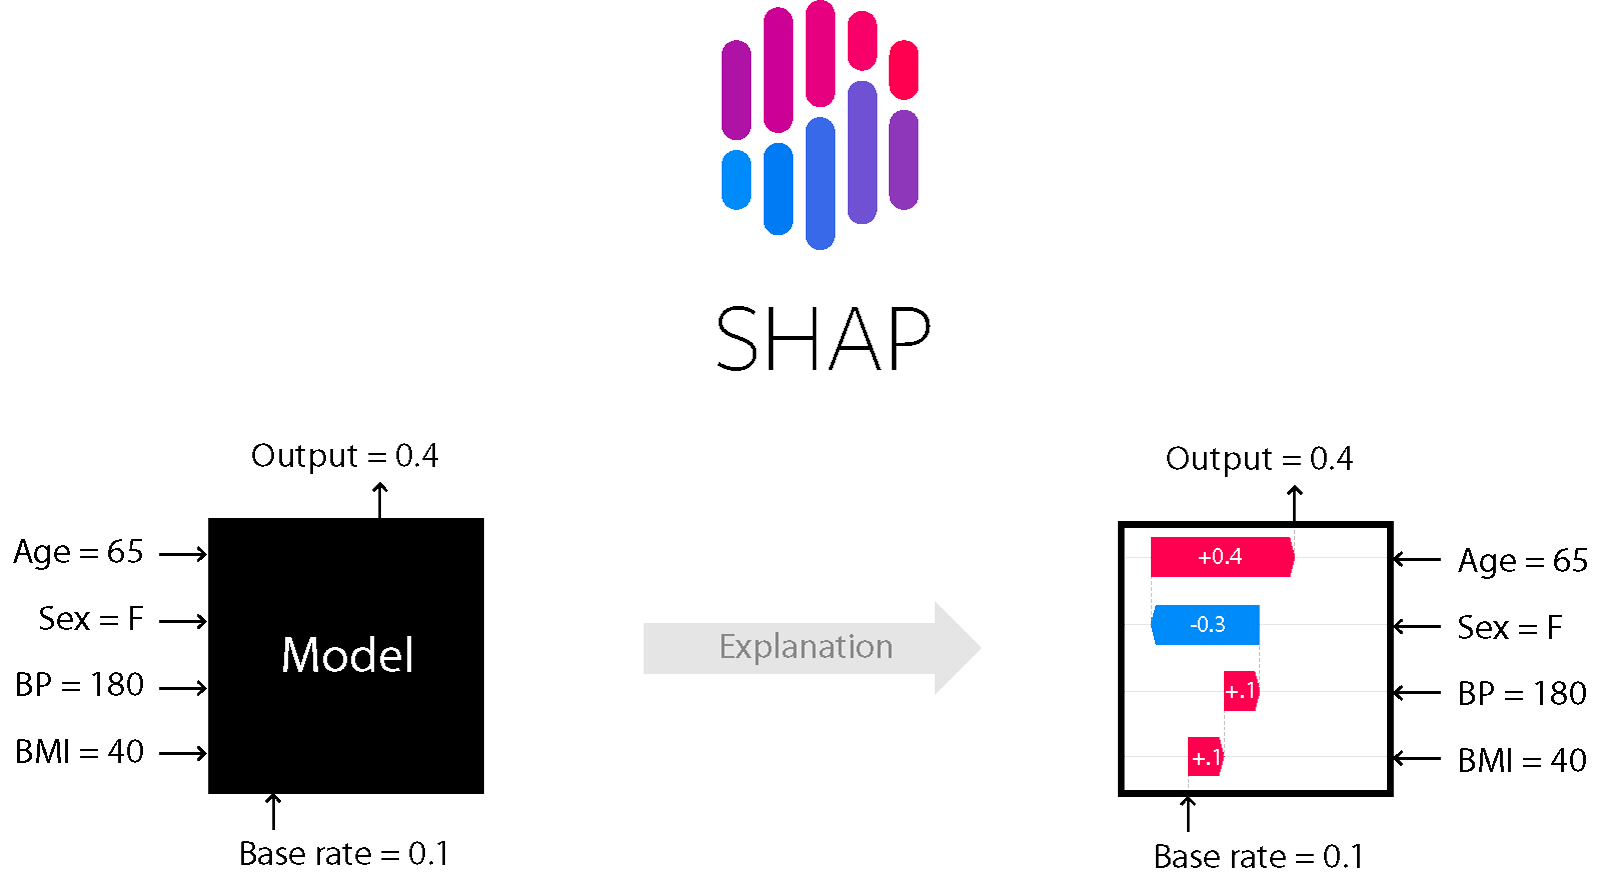

SHAP (SHapley Additive exPlanations) is a methodology for explaining machine learning predictions based on cooperative game theory.

**Cooperative Game Theory:**

In game theory, is branch of mathematics that studies interactions between rational agents. Cooperative game theory specifically examines scenarios where players can form coalitions and work together to achieve better outcomes than they could individually. The main goal is to determine how to distribute the collective payoff fairly among participants based on their contributions.

**Players:**

In cooperative game theory, players represent the individual agents that contribute to a collective outcome. Each player has the potential to collaborate with others to increase the total utility or payoff generated by their combined efforts. In the context of Machine Learning players are represented by features.

**Coalitions:**

A coalition refers to a subset of players that collaborate to achieve a specific outcome. The calculation of Shapley values considers all possible coalitions, determining how much each feature adds to the prediction when included in any combination of other features.

**Utility Function:**

A utility function represents the total value or payoff that a coalition of players (features) can achieve by working together. It helps quantify the contribution of each feature to the model's prediction. In the context of Machine Learning utility is represented by difference with a random classifier.

**Shapley Values:**

Shapley values are derived from cooperative game theory and provide a method for fairly distributing the total utility among the players based on their contributions. Each Shapley value reflects the marginal contribution of a feature to the overall prediction.
The calculation considers all possible combinations of features and determines how much each feature adds to the prediction when included in a coalition of other features.

**Computational complexity:**

The computation of Shapley values has a high computational complexity, which is equal to 2n2n, where nn is the number of features. This exponential complexity arises from the need to evaluate all possible combinations of features (or coalitions) to accurately assess each feature's contribution to the model's predictions. As the number of features increases, the computational burden grows significantly, making exact calculations impractical for models with many features. One common solution to mitigate this complexity is to use sampling techniques that evaluate a subset of features instead of all possible combinations, allowing for a more manageable computation while still providing valuable insights.

Implementation:

* Exact SHAP: Computes precise values but can be computationally expensive for
large datasets.
* Kernel SHAP: An approximate method applicable to any model, using sampling to estimate Shapley values.
* Tree SHAP: Efficiently computes exact values for tree-based models like decision trees and gradient boosting machines.
* Partition SHAP: Efficiently computes the value foir highly dimensional datasets (such as images).

Visualization Tools (available in SHAP):

* Summary Plots: Show the distribution of feature importance across the dataset.
* Force Plots: Illustrate individual feature contributions to specific predictions.
* Dependence Plots: Explore relationships between features and predictions, accounting for interactions with other features.

## 📖 TL;DR

SHAP is a method for explaining black-boc predictions in Machine Learning. It is based on Game Theory and in particular Cooperative Game Theory.

Fundamental Cooperative Game Theory concepts:

* Utility function: the total value of the game --> in ML is represented by the difference with a random classifier.
* Players: individual agents that splits the utility function --> in ML are represented by the features of the problem.
* Shapley value: fair distribution strategy between players

In [1]:
!pip install shap

  Using cached shap-0.46.0-cp312-cp312-win_amd64.whl.metadata (25 kB)
  Using cached slicer-0.0.8-py3-none-any.whl.metadata (4.0 kB)
  Using cached numba-0.60.0-cp312-cp312-win_amd64.whl.metadata (2.8 kB)
  Using cached cloudpickle-3.1.0-py3-none-any.whl.metadata (7.0 kB)
  Using cached llvmlite-0.43.0-cp312-cp312-win_amd64.whl.metadata (4.9 kB)
Using cached shap-0.46.0-cp312-cp312-win_amd64.whl (456 kB)
Using cached slicer-0.0.8-py3-none-any.whl (15 kB)
Using cached cloudpickle-3.1.0-py3-none-any.whl (22 kB)
Using cached numba-0.60.0-cp312-cp312-win_amd64.whl (2.7 MB)
Using cached llvmlite-0.43.0-cp312-cp312-win_amd64.whl (28.1 MB)



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import shap
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

c:\Users\lperf\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Dataset and preprocessing

In [3]:
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target
y = to_categorical(y)
print(f"Dimensioni del dataset: {X.shape}")

Dimensioni del dataset: (569, 30)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### DL Model

In [5]:
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train_scaled, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

c:\Users\lperf\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.4566 - loss: 0.7257 - val_accuracy: 0.9011 - val_loss: 0.5224
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9277 - loss: 0.4852 - val_accuracy: 0.9560 - val_loss: 0.3667
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9434 - loss: 0.3501 - val_accuracy: 0.9560 - val_loss: 0.2647
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9453 - loss: 0.2470 - val_accuracy: 0.9560 - val_loss: 0.2015
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9510 - loss: 0.1949 - val_accuracy: 0.9670 - val_loss: 0.1630
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9539 - loss: 0.1379 - val_accuracy: 0.9780 - val_loss: 0.1389
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9822 - loss: 0.1082 - val_accuracy: 0.9780 - val_loss: 0.1238
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9873 - loss: 0.0925 - val_accuracy: 0.9780 - val_los

### SHAP (1): Create the object

KernelExplainer is the implementation of the computation of basic SHAP value as the formula in cooperative game theory.

```python
explainer = shap.KernelExplainer(model.predict, data, feature_names)
```

* `model`: Model's predict function. Use to calculate the utility function. It should be defined in the range 0-1.

* `data`: Background dataset used to simulate the absence of a feature.

* `feature_names`: The names of the features in the background dataset.

In [6]:
explainer = shap.KernelExplainer(model.predict, X_train_scaled[:100])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


### Shap (2): computes Shapley Value

```python
explainer.shap_values(data, nsamples=100)
```

* `data`: elements to explain

* `nsamples`: Number of samples for estimating the Shapley Value.

In [7]:
shap_values = explainer.shap_values(X_test_scaled[0:10], nsamples='auto')
exp_obj = shap.Explanation(shap_values,base_values=explainer.expected_value,data=X_test_scaled[0:10], feature_names=X.columns)

  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 10%|█         | 1/10 [00:11<01:39, 11.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 20%|██        | 2/10 [00:20<01:21, 10.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 30%|███       | 3/10 [00:30<01:08,  9.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 40%|████      | 4/10 [00:39<00:57,  9.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 50%|█████     | 5/10 [00:48<00:47,  9.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 7s 999us/step


 60%|██████    | 6/10 [00:58<00:37,  9.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 70%|███████   | 7/10 [01:07<00:28,  9.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 6s 964us/step


 80%|████████  | 8/10 [01:16<00:18,  9.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 6s 981us/step


 90%|█████████ | 9/10 [01:25<00:09,  9.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 6s 978us/step


100%|██████████| 10/10 [01:35<00:00,  9.50s/it]


In [8]:
print(f"Shap result dimension: {exp_obj.shape}")

Shap result dimension: (10, 30, 2)


### 📊 Visualize Results

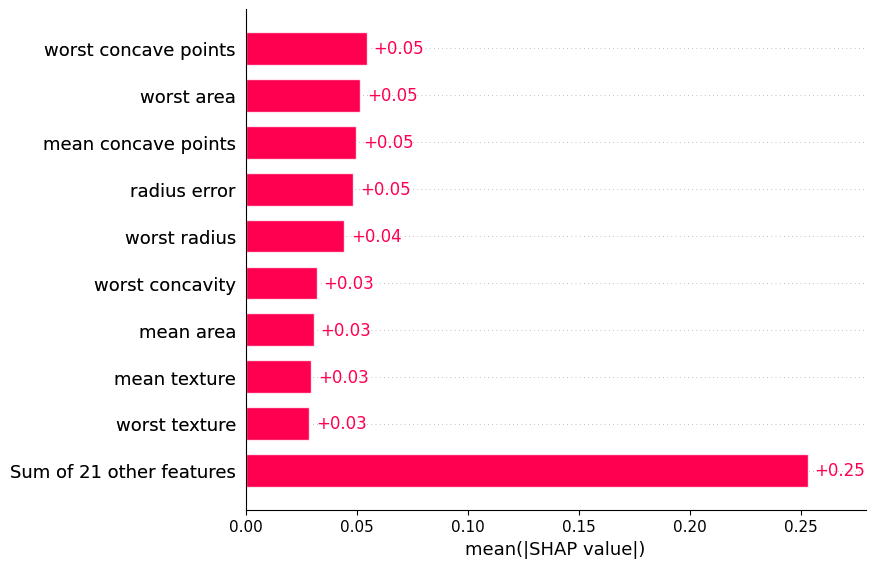

In [9]:
shap.plots.bar(exp_obj[:,:,0])

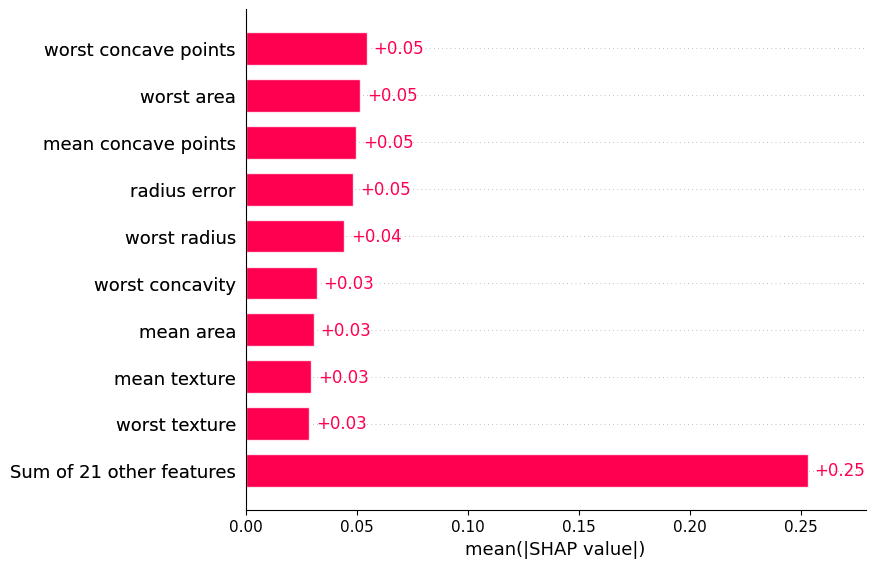

In [10]:
shap.plots.bar(exp_obj[:,:,1])

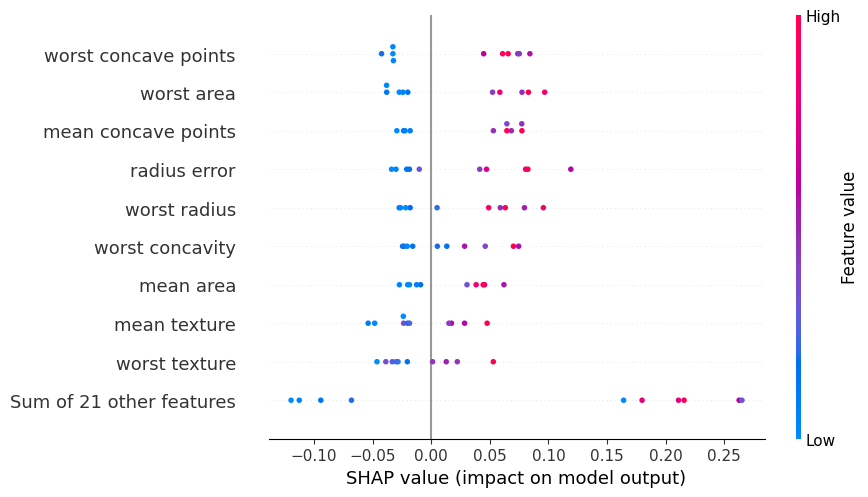

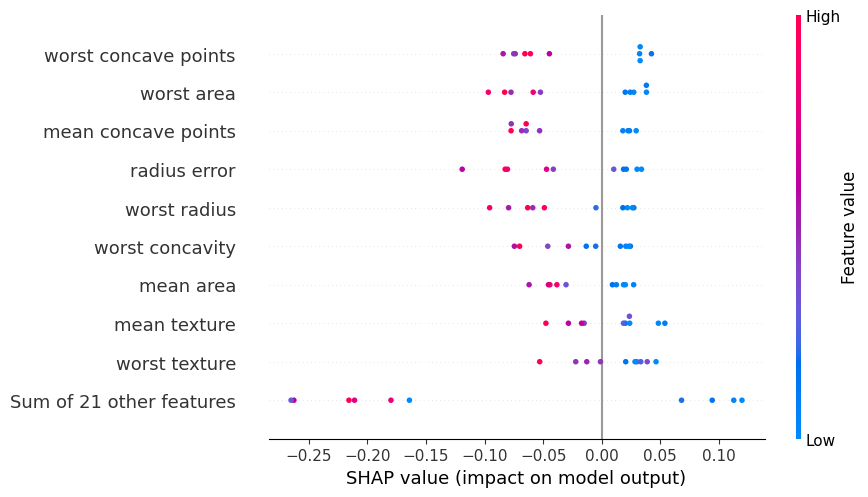

In [11]:
shap.plots.beeswarm(exp_obj[:,:,0])
shap.plots.beeswarm(exp_obj[:,:,1])

### Inspect single explanation



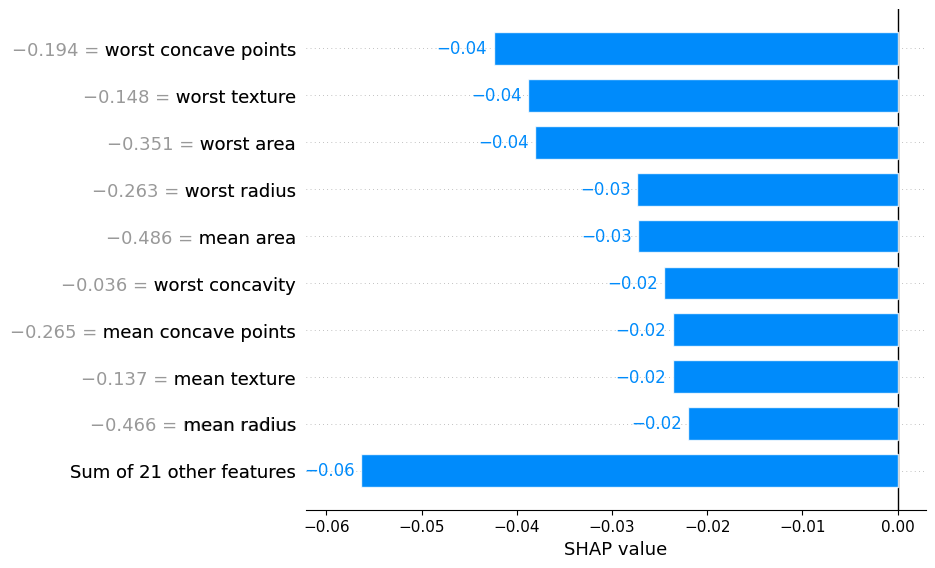

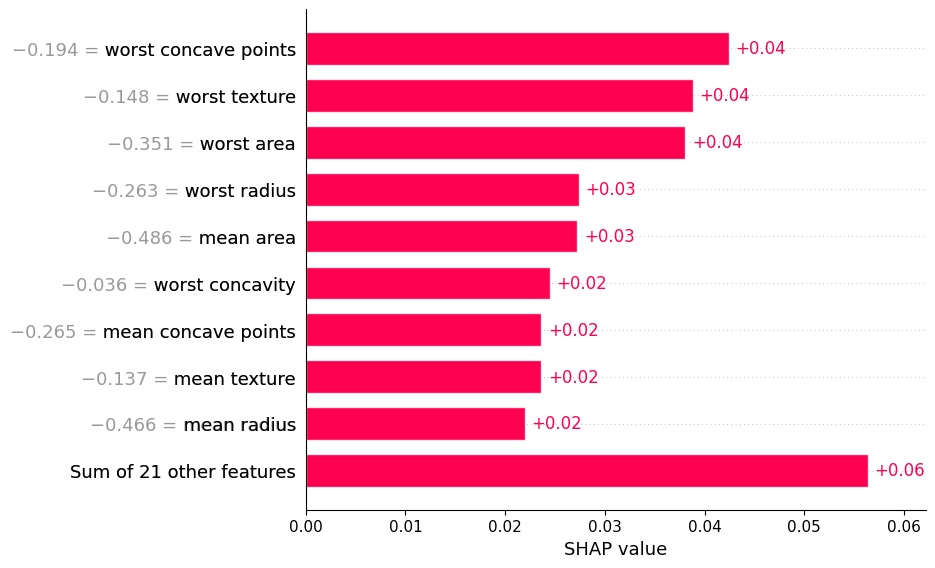

In [12]:
shap.plots.bar(exp_obj[0,:,0])
shap.plots.bar(exp_obj[0,:,1])

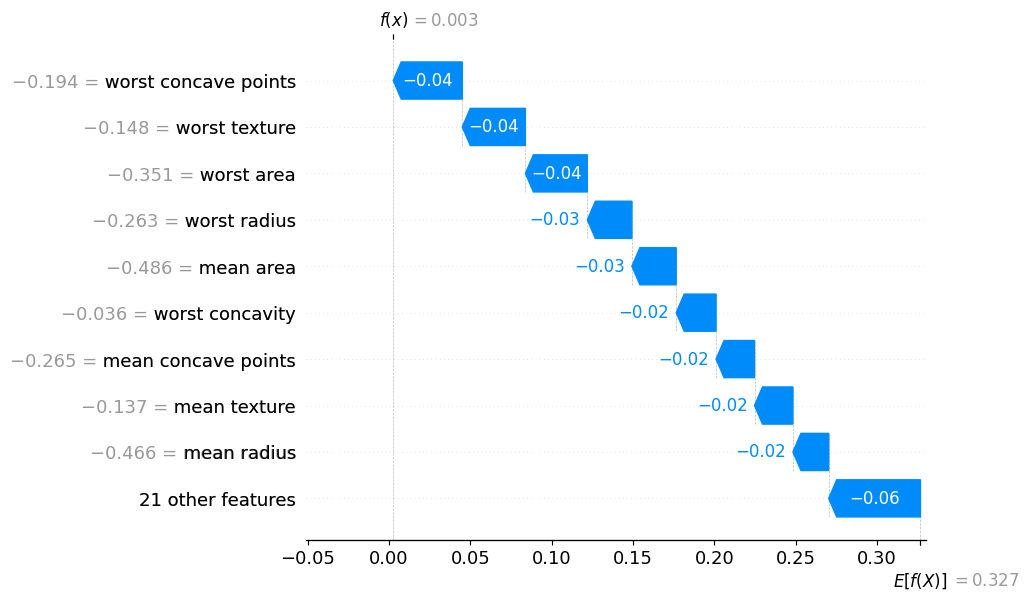

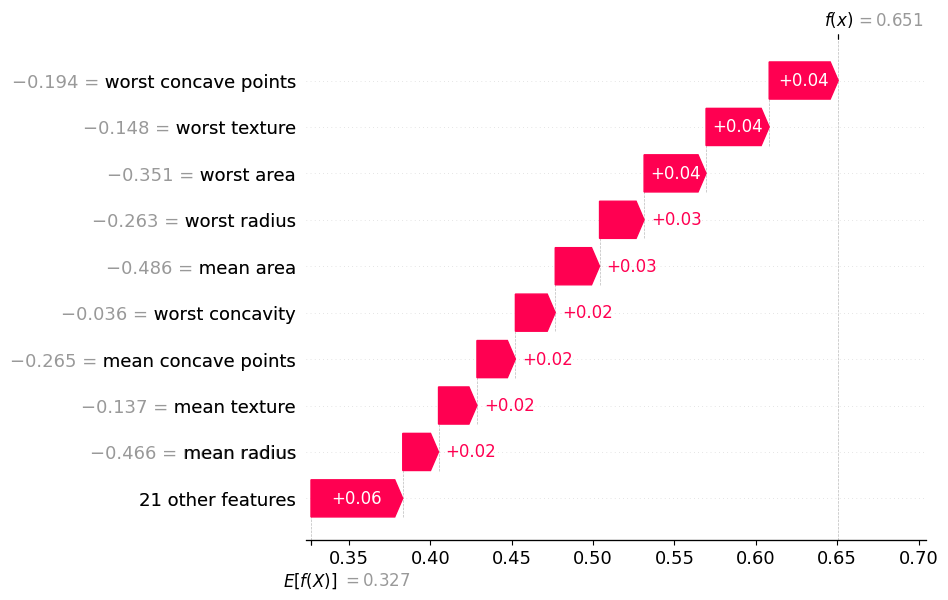

In [13]:
shap.plots.waterfall(exp_obj[0,:,0])
shap.plots.waterfall(exp_obj[0,:,1])

In [14]:
shap_values_complete = explainer.shap_values(X_test_scaled, nsamples=100)
exp_obj_complete = shap.Explanation(shap_values_complete,base_values=explainer.expected_value,data=X_test_scaled, feature_names=X.columns)

  0%|          | 0/114 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  1%|          | 1/114 [00:00<01:30,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step


  2%|▏         | 2/114 [00:01<01:22,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  3%|▎         | 3/114 [00:02<01:23,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  4%|▎         | 4/114 [00:02<01:22,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  4%|▍         | 5/114 [00:03<01:22,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  5%|▌         | 6/114 [00:04<01:21,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step


  6%|▌         | 7/114 [00:05<01:28,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  7%|▋         | 8/114 [00:06<01:21,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step


  8%|▊         | 9/114 [00:06<01:17,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  9%|▉         | 10/114 [00:07<01:25,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 10%|▉         | 11/114 [00:08<01:20,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 11%|█         | 12/114 [00:09<01:18,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 11%|█▏        | 13/114 [00:09<01:16,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 12%|█▏        | 14/114 [00:10<01:18,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 13%|█▎        | 15/114 [00:11<01:17,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 14%|█▍        | 16/114 [00:12<01:20,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 15%|█▍        | 17/114 [00:13<01:20,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 16%|█▌        | 18/114 [00:14<01:18,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 17%|█▋        | 19/114 [00:14<01:16,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 18%|█▊        | 20/114 [00:16<01:25,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 18%|█▊        | 21/114 [00:17<01:43,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 19%|█▉        | 22/114 [00:18<01:42,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 20%|██        | 23/114 [00:19<01:33,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 21%|██        | 24/114 [00:20<01:26,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 22%|██▏       | 25/114 [00:21<01:29,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 23%|██▎       | 26/114 [00:22<01:20,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 24%|██▎       | 27/114 [00:22<01:14,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 25%|██▍       | 28/114 [00:23<01:12,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 25%|██▌       | 29/114 [00:24<01:07,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 26%|██▋       | 30/114 [00:25<01:15,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 27%|██▋       | 31/114 [00:26<01:16,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step


 28%|██▊       | 32/114 [00:27<01:09,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 29%|██▉       | 33/114 [00:27<01:05,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step


 30%|██▉       | 34/114 [00:28<01:02,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step


 31%|███       | 35/114 [00:29<00:58,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 32%|███▏      | 36/114 [00:30<00:55,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 32%|███▏      | 37/114 [00:30<00:54,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 33%|███▎      | 38/114 [00:31<00:53,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step


 34%|███▍      | 39/114 [00:32<00:51,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step


 35%|███▌      | 40/114 [00:32<00:56,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step


 36%|███▌      | 41/114 [00:33<00:52,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 37%|███▋      | 42/114 [00:34<00:59,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 38%|███▊      | 43/114 [00:35<00:58,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 39%|███▊      | 44/114 [00:36<00:56,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 39%|███▉      | 45/114 [00:37<00:55,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 40%|████      | 46/114 [00:37<00:54,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 41%|████      | 47/114 [00:38<00:52,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 42%|████▏     | 48/114 [00:39<00:53,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 43%|████▎     | 49/114 [00:40<00:55,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 44%|████▍     | 50/114 [00:41<00:54,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 45%|████▍     | 51/114 [00:42<00:52,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 46%|████▌     | 52/114 [00:42<00:50,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 46%|████▋     | 53/114 [00:43<00:48,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 47%|████▋     | 54/114 [00:44<00:48,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 48%|████▊     | 55/114 [00:45<00:48,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 49%|████▉     | 56/114 [00:46<00:49,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 50%|█████     | 57/114 [00:47<00:49,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 51%|█████     | 58/114 [00:47<00:48,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 52%|█████▏    | 59/114 [00:48<00:46,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 53%|█████▎    | 60/114 [00:49<00:44,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 54%|█████▎    | 61/114 [00:50<00:46,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 54%|█████▍    | 62/114 [00:51<00:45,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 55%|█████▌    | 63/114 [00:52<00:43,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 56%|█████▌    | 64/114 [00:52<00:41,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 57%|█████▋    | 65/114 [00:53<00:40,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 58%|█████▊    | 66/114 [00:54<00:39,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 59%|█████▉    | 67/114 [00:55<00:39,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 60%|█████▉    | 68/114 [00:56<00:38,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 61%|██████    | 69/114 [00:57<00:38,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 61%|██████▏   | 70/114 [00:57<00:36,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 62%|██████▏   | 71/114 [00:58<00:35,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 63%|██████▎   | 72/114 [00:59<00:34,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 64%|██████▍   | 73/114 [01:00<00:33,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 65%|██████▍   | 74/114 [01:01<00:35,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 66%|██████▌   | 75/114 [01:02<00:34,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 67%|██████▋   | 76/114 [01:03<00:33,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 68%|██████▊   | 77/114 [01:04<00:31,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 68%|██████▊   | 78/114 [01:04<00:31,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 69%|██████▉   | 79/114 [01:05<00:30,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 70%|███████   | 80/114 [01:06<00:29,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 71%|███████   | 81/114 [01:07<00:29,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 72%|███████▏  | 82/114 [01:08<00:28,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 73%|███████▎  | 83/114 [01:09<00:27,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 74%|███████▎  | 84/114 [01:10<00:26,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 75%|███████▍  | 85/114 [01:11<00:25,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 75%|███████▌  | 86/114 [01:11<00:23,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 76%|███████▋  | 87/114 [01:12<00:23,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 77%|███████▋  | 88/114 [01:13<00:23,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 78%|███████▊  | 89/114 [01:14<00:21,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 79%|███████▉  | 90/114 [01:15<00:20,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 80%|███████▉  | 91/114 [01:16<00:19,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 81%|████████  | 92/114 [01:17<00:18,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 82%|████████▏ | 93/114 [01:18<00:21,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


 82%|████████▏ | 94/114 [01:20<00:28,  1.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


 83%|████████▎ | 95/114 [01:23<00:33,  1.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 84%|████████▍ | 96/114 [01:25<00:34,  1.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 85%|████████▌ | 97/114 [01:27<00:29,  1.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 86%|████████▌ | 98/114 [01:28<00:24,  1.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 87%|████████▋ | 99/114 [01:28<00:19,  1.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 88%|████████▊ | 100/114 [01:29<00:16,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 89%|████████▊ | 101/114 [01:31<00:16,  1.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 89%|████████▉ | 102/114 [01:31<00:13,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step


 90%|█████████ | 103/114 [01:32<00:10,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 91%|█████████ | 104/114 [01:33<00:09,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 92%|█████████▏| 105/114 [01:34<00:08,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 93%|█████████▎| 106/114 [01:35<00:07,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 94%|█████████▍| 107/114 [01:36<00:06,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 95%|█████████▍| 108/114 [01:37<00:05,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 96%|█████████▌| 109/114 [01:38<00:05,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


 96%|█████████▋| 110/114 [01:41<00:06,  1.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 97%|█████████▋| 111/114 [01:42<00:04,  1.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 98%|█████████▊| 112/114 [01:43<00:02,  1.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 99%|█████████▉| 113/114 [01:44<00:01,  1.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


100%|██████████| 114/114 [01:45<00:00,  1.08it/s]


In [15]:
print(f"Shap result dimension: {exp_obj_complete.shape}")

Shap result dimension: (114, 30, 2)


### 📊 Visualize results

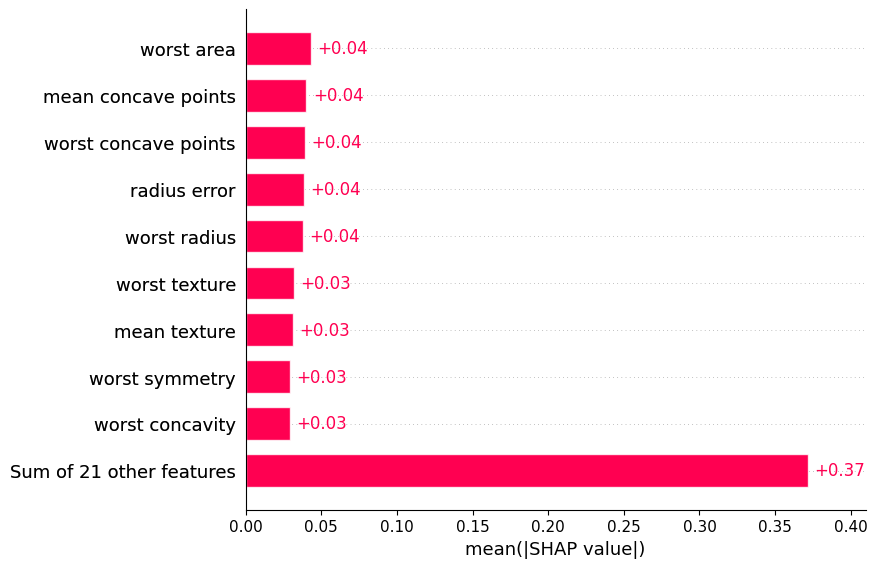

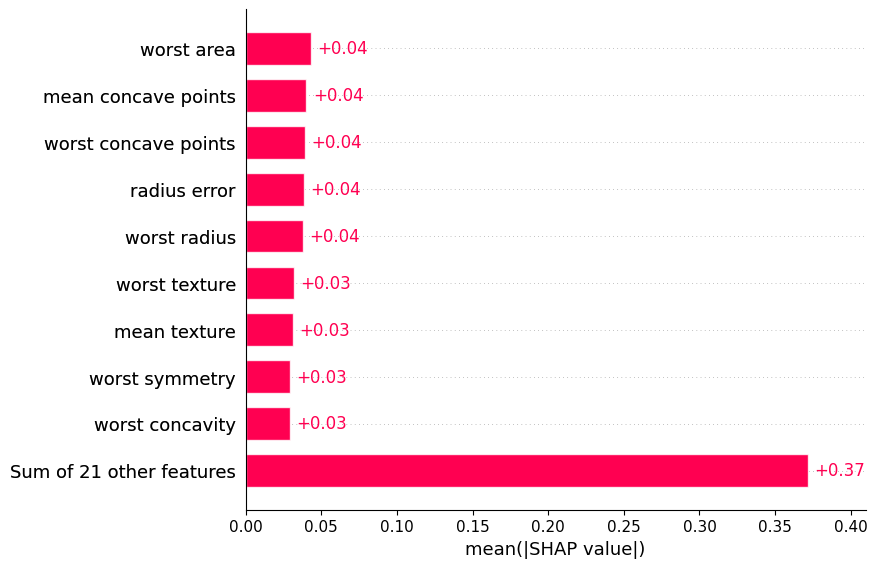

In [16]:
#average plot

shap.plots.bar(exp_obj_complete[:,:,0])
shap.plots.bar(exp_obj_complete[:,:,1])

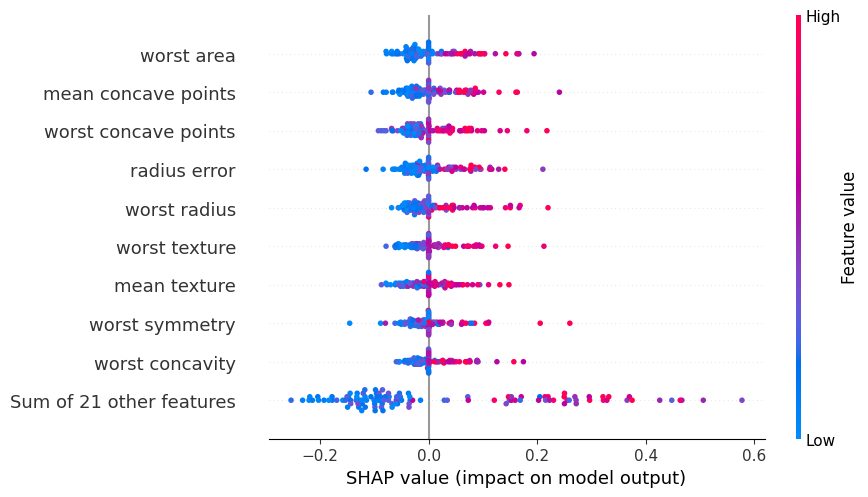

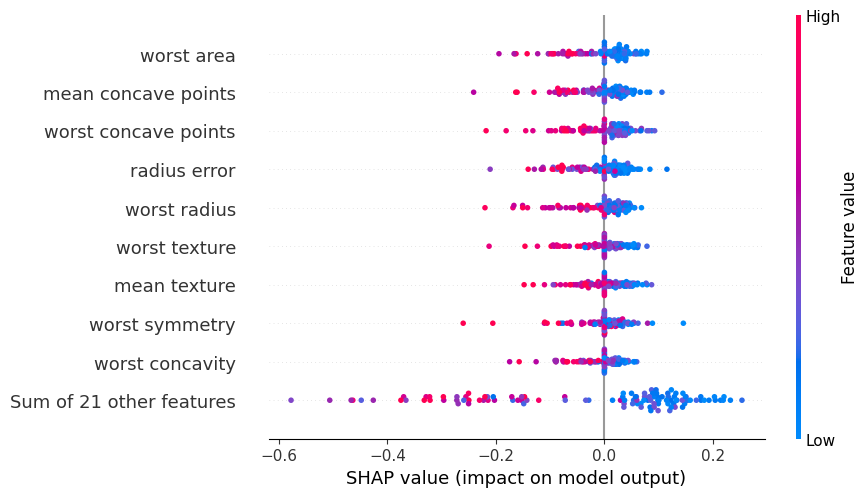

In [17]:
shap.plots.beeswarm(exp_obj_complete[:,:,0])
shap.plots.beeswarm(exp_obj_complete[:,:,1])

### Inspect single explanation

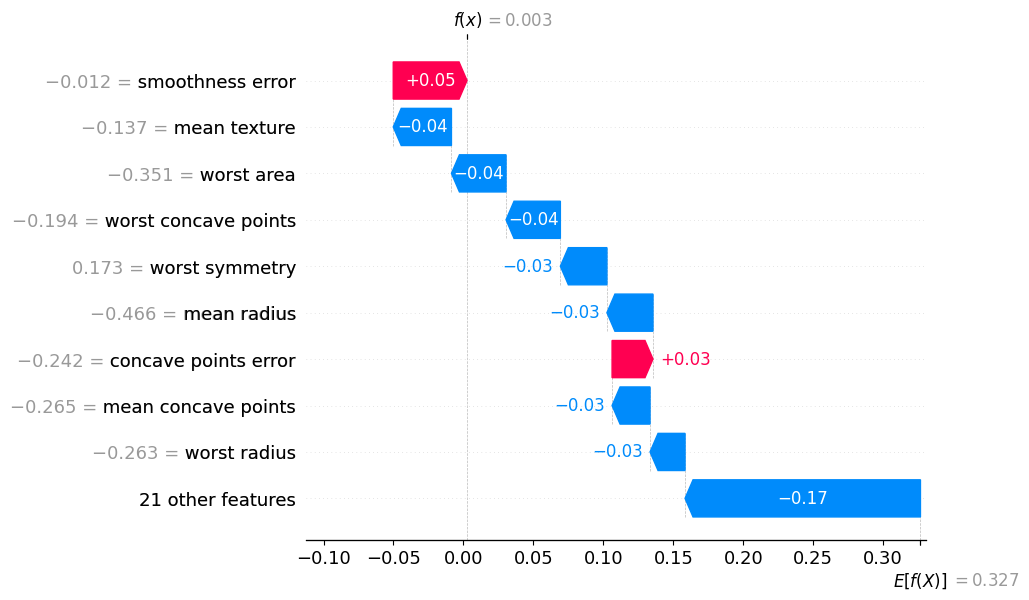

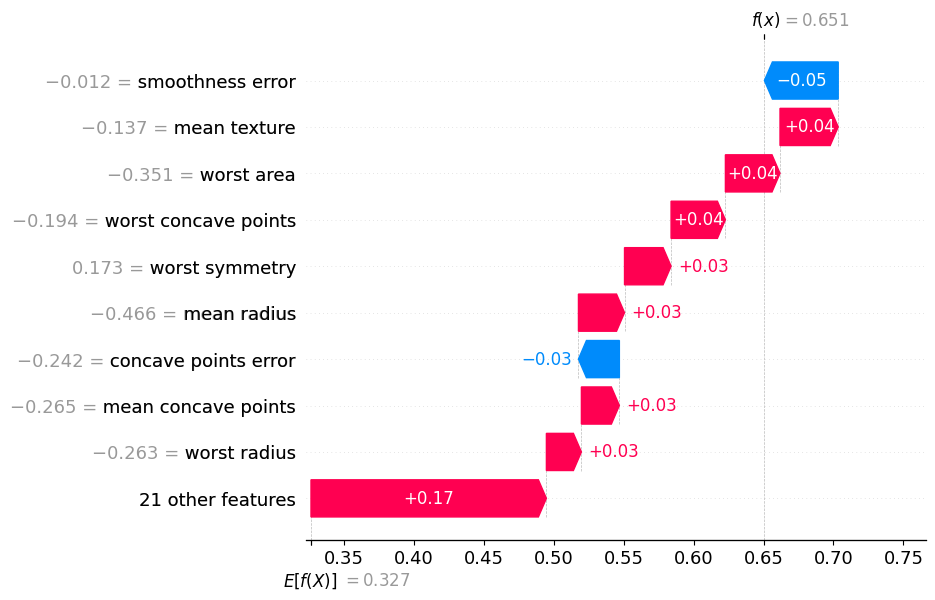

In [18]:
shap.plots.waterfall(exp_obj_complete[0,:,0])
shap.plots.waterfall(exp_obj_complete[0,:,1])

# LIME

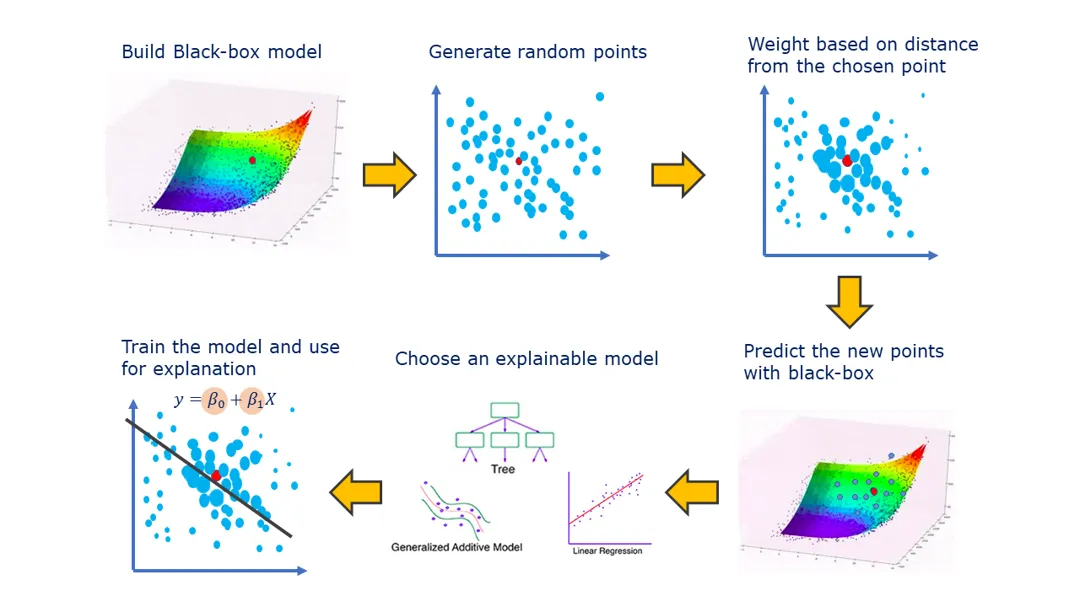

LIME is a technique designed to make the predictions of complex machine learning models more understandable. It operates by creating a simpler, interpretable model that approximates the behavior of the black-box model in the region around a specific prediction. To do this, LIME generates slightly modified versions of the input data and analyzes how these changes impact the model's output. This allows LIME to build a local, linear model that highlights the contribution of each feature to the prediction, providing a clear, human-readable explanation of the factors influencing the model's decision for that particular instance. This approach makes it possible to interpret and trust the results of even the most sophisticated AI systems.

**Perturbation of data points**

LIME creates many variations of the input data by slightly altering its features. This process, called perturbation, involves randomly modifying feature values to generate new samples around the original instance. By observing how these perturbations affect the model's predictions, LIME can understand how sensitive the model is to changes in each feature.

**Weighting of data samples**

Once the perturbations are created, LIME assigns weights to these new samples based on their similarity to the original data point. Samples that are more similar to the original instance receive higher weights, ensuring that the explanation focuses on the local behavior of the model. This helps in accurately capturing how the model behaves specifically around that particular prediction.

**Local linear model**

LIME uses the weighted data samples to train a simple, interpretable linear model that approximates the predictions of the black-box model locally. Even if the original model is highly complex and non-linear, this linear approximation provides a straightforward way to understand which features are most influential in the specific context of the prediction. The linear model is chosen because of its transparency and ease of interpretation.

**Feature importance extraction**

The coefficients of the linear model directly indicate the importance of each feature for the prediction. A higher coefficient means that the corresponding feature has a stronger influence on the model's decision. This step transforms the complex decision-making process of the black-box model into a more human-understandable explanation of how different features contribute to the result.

## 📖 TL;DR

LIME is a XAI technique designed to explain AI models by providing localized explanations for individual predictions.

*   Builds a simple, **linear model** that closely mimics the behavior of the complex AI model for a specific prediction, making the results easier to understand.
*   **Perturbs** the input data by making small changes to its features, then observes how these changes impact the model's predictions to analyze its sensitivity.
* Uses a **weighted scheme** to focus on data points that are most similar to the original instance, and then creates a local linear model that highlights the key features driving the prediction.

In [19]:
! pip install lime

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
   ------- -------------------------------- 2.4/12.9 MB 12.2 MB/s eta 0:00:01
   -------------- ------------------------- 4.7/12.9 MB 11.4 MB/s eta 0:00:01
   ---------------------- ----------------- 7.3/12.9 MB 11.6 MB/s eta 0:00:01
   ------------------------------- -------- 10.2/12.9 MB 12.0 MB/s eta 0:00:01
   ---------------------------------------  12.8/12.9 MB 12.2 MB/s eta 0:00:01
   ---------------------------------------- 12.9/12.9 MB 11.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 1.7/1.7 MB 10.4 MB/s eta 0:00:00
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283842 sha256=223dcc2f23dcebbe9abcbda716a872b8d2cd4b3b79101d34a10ea1d9e8c8c047
  Stored in directory: c:\users\lperf\appdata\local\pip\cache\


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [20]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt
from lime import lime_tabular

### Dataset and preprocessing

In [21]:
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target
y = to_categorical(y)
print(f"Dimensioni del dataset: {X.shape}")

Dimensioni del dataset: (569, 30)


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### DL Model

In [23]:
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train_scaled, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/20


c:\Users\lperf\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3955 - loss: 0.7210 - val_accuracy: 0.8791 - val_loss: 0.5454
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9178 - loss: 0.5252 - val_accuracy: 0.9670 - val_loss: 0.4257
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9381 - loss: 0.3965 - val_accuracy: 0.9341 - val_loss: 0.3157
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9548 - loss: 0.2768 - val_accuracy: 0.9560 - val_loss: 0.2292
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9331 - loss: 0.2320 - val_accuracy: 0.9670 - val_loss: 0.1776
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9462 - loss: 0.1615 - val_accuracy: 0.9670 - val_loss: 0.1457
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9545 - loss: 0.1441 - val_accuracy: 0.9670 - val_loss: 0.1261
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9776 - loss: 0.1009 - val_accuracy: 0.9670 - val_loss: 0.1137
Ep

### LIME (1): create object

LimeTabularExplainer is the object for manipulating tabular data.

```
LimeTabularExplainer(training_data, feature_names=X.columns, class_names=['Malignant', 'Benign'], mode='classification')
```
* `training_data`: numpy 2d array

* `class_names`: list of class names, ordered according to whatever the classifier is using.

* `feature_names`:  list of class names, ordered according to whatever the classifier is using.

* `mode`: “classification” or “regression”


In [24]:
explainer = lime_tabular.LimeTabularExplainer(X_train_scaled, feature_names=X.columns, class_names=['Malignant', 'Benign'], mode='classification')

### Lime (2): explain one instance

LimeTabularExplainer is the object for manipulating tabular data.

```
explainer.explain_instance(instance, predict_fn, num_features=10, top_labels=2)
```
* `instance`: 1d numpy array or scipy.sparse matrix, corresponding to a row.

* `predict_fn`: prediction function.

* `num_features`:  maximum number of features present in explanation.

* `top_labels`: if not None, ignore labels and produce explanations for the K labels with highest prediction probabilities, where K is this parameter.

In [25]:
instance = X_test_scaled[0]

exp = explainer.explain_instance(instance, model.predict, num_features=10, top_labels=2)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


### Visualize results (1): single instance

In [26]:
exp.show_in_notebook(show_table=True, show_all=False)

In [27]:
def map_to_array(map):
  names = []
  values = []
  for v in map:
    names.append(X.columns.values[v[0]])
    values.append(v[1])
  return np.array(names), np.array(values)

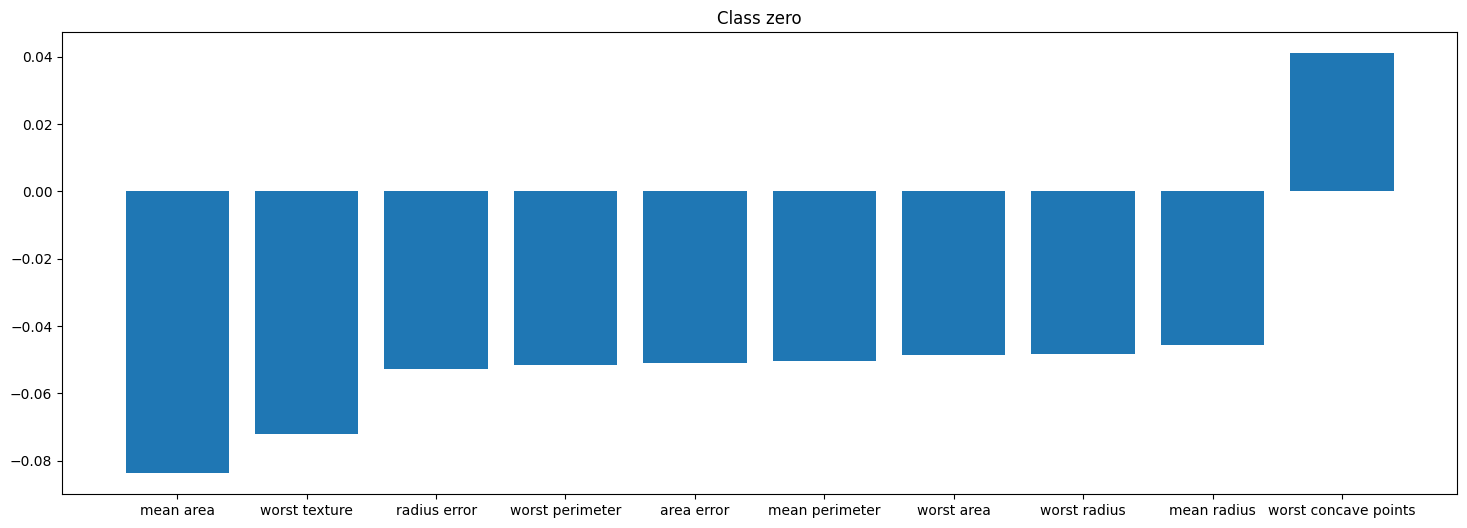

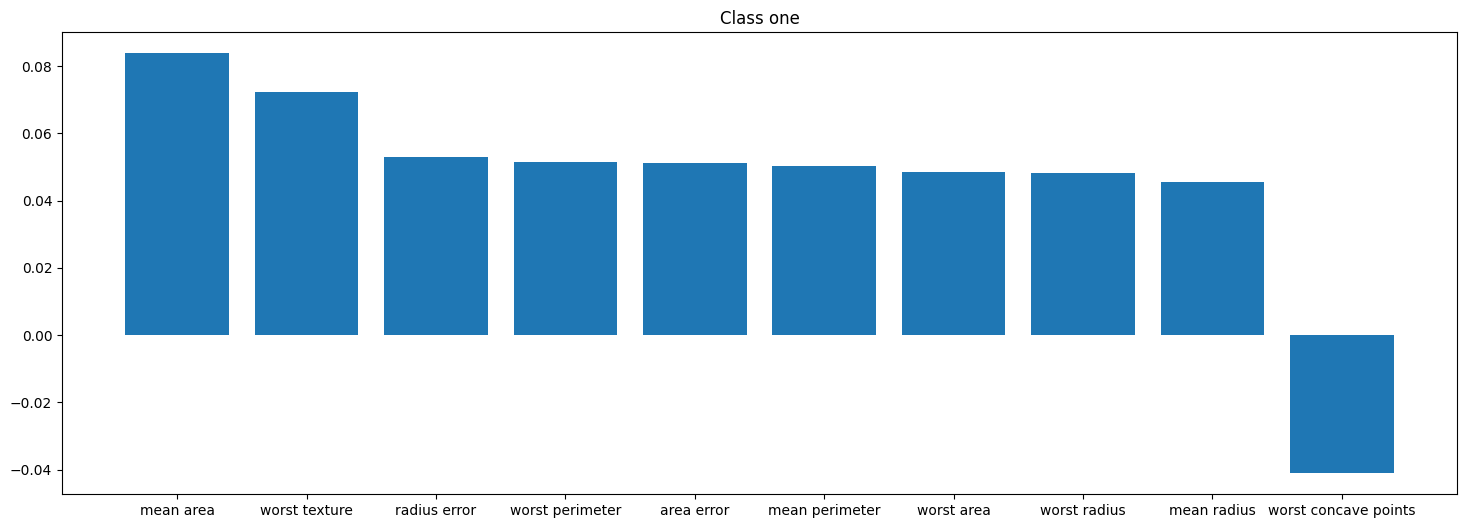

In [28]:
feature_importance = exp.as_map()

names, values = map_to_array(feature_importance[0])

plt.figure(figsize=(18, 6))
plt.bar(names, values)
plt.title("Class zero")
plt.show()

names, values = map_to_array(feature_importance[1])

plt.figure(figsize=(18, 6))
plt.bar(names, values)
plt.title("Class one")
plt.show()

### Visualize results (2): entire dataset

In [29]:
def lime_results_to_heatmap(exp, class_label, input_dimension):
    exp_map = exp.as_map()[class_label]
    hm = np.zeros(input_dimension)
    for e in exp_map:
        hm[e[0]] = e[1]
    return np.array(hm)

In [30]:
heatmaps = []

for i in range(len(X_test_scaled)):
  instance = X_test_scaled[i]
  exp = explainer.explain_instance(instance, model.predict, num_features=30, top_labels=2)
  hm_class = []
  for j in range(2): #number of classes
    hm = lime_results_to_heatmap(exp, j, 30)
    hm_class.append(hm)
  heatmaps.append(hm_class)

heatmaps = np.array(heatmaps)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━

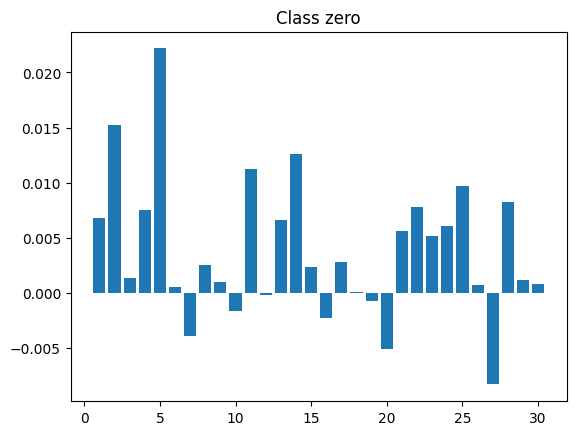

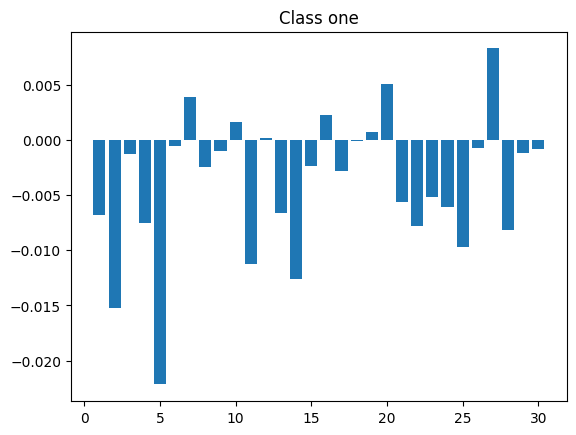

In [31]:
avg_vals = np.mean(heatmaps[:,0,:], axis=0)
std_vals = np.std(heatmaps[:,0,:], axis=0)

plt.bar(np.arange(1, 31), avg_vals)
plt.title("Class zero")
plt.show()


avg_vals = np.mean(heatmaps[:,1,:], axis=0)
std_vals = np.std(heatmaps[:,1,:], axis=0)

plt.bar(np.arange(1, 31), avg_vals)
plt.title("Class one")
plt.show()

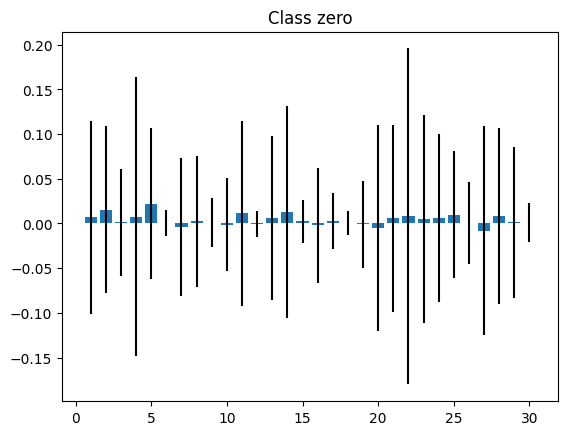

In [32]:
avg_vals = np.mean(heatmaps[:,0,:], axis=0)
std_vals = np.std(heatmaps[:,0,:], axis=0)

plt.bar(np.arange(1, 31), avg_vals, yerr=std_vals)
plt.title("Class zero")
plt.show()

# 📕 Exercise



1.   Take the dataset (Default Credit Card Prediction)
2.   Train a DNN (or any other model)
3.  Explain model predictions with SHAP and LIME (play around with the different hyperparameters)
4.  Create a ranking of the features that appear to be most important for both methods? Do the two methods agree or not?
5. Compare the important features for positively and negatively classified test elements

